#  정보 검색 평가지표(HitRate, MRR, NDCG) 이해

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) langfuase handler 설정`

In [ ]:
from langfuse.langchain import CallbackHandler

# LangChain 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

---

## **평가 지표** (Evaluation Metric)

#### 1) **검색(Retrieval) 평가**  

- **Non-Rank Based Metrics**: Accuracy, Precision, Recall@k 등을 통해 관련성의 이진적 평가를 수행  

- **Rank-Based Metrics**: MRR(Mean Reciprocal Rank), MAP(Mean Average Precision)를 통해 검색 결과의 순위를 고려한 평가를 수행

- **RAG 특화 지표**: 기존 검색 평가 방식의 한계를 보완하는 LLM-as-judge 방식 도입

- **포괄적 평가**: 정확도, 관련성, 다양성, 강건성을 통합적으로 측정

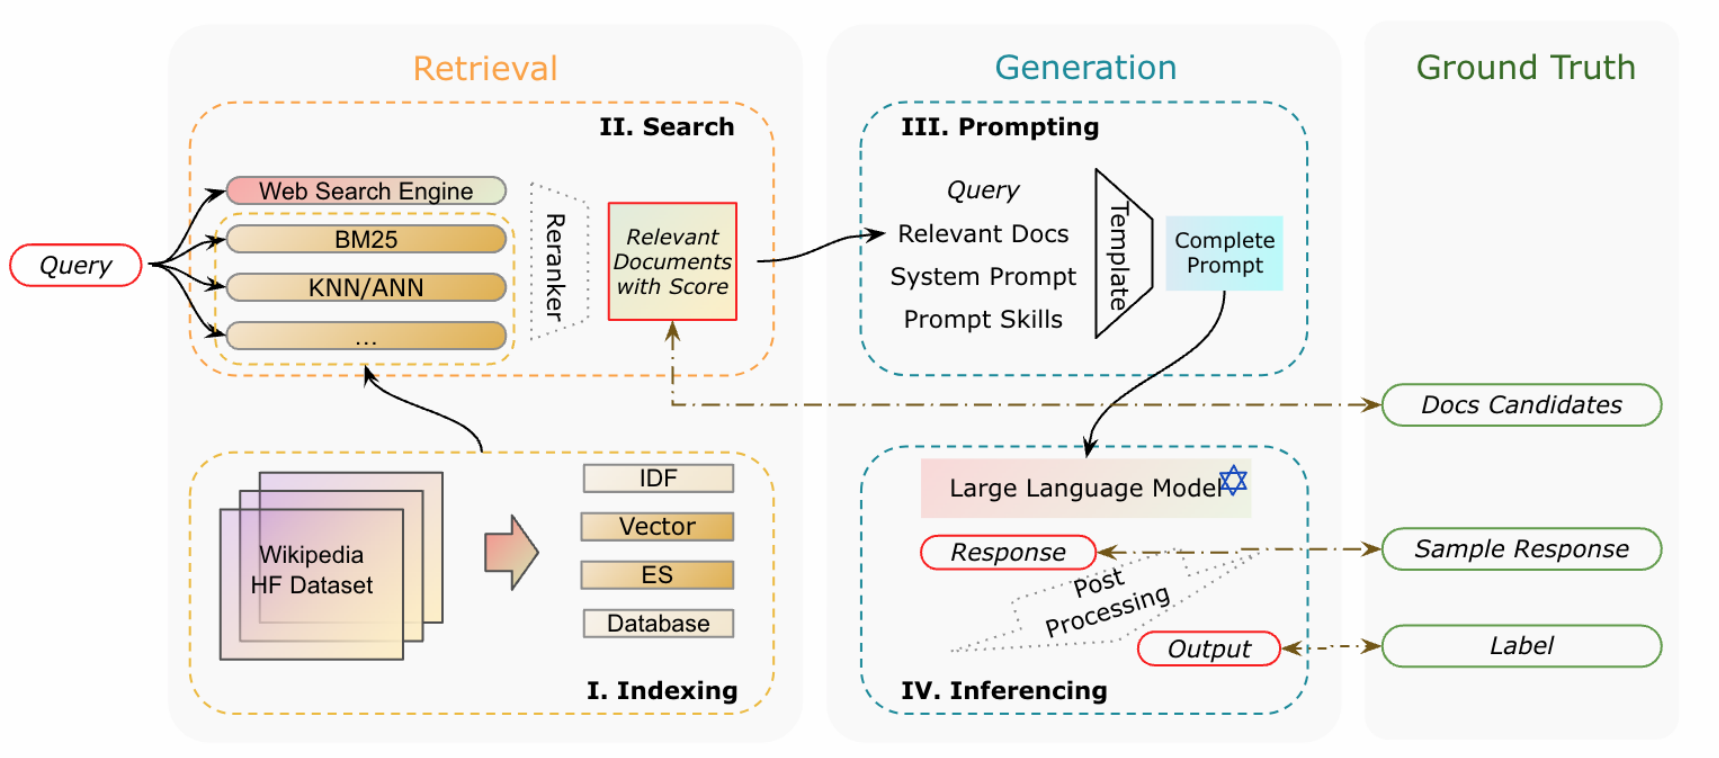


#### 2) **생성(Generation) 평가**

- **전통적 평가**: ROUGE(요약), BLEU(번역), BertScore(의미 유사도) 지표 활용

- **LLM 기반 평가**: 응집성, 관련성, 유창성을 종합적으로 판단하는 새로운 접근법 도입 (전통적인 참조 비교가 어려운 상황에서 유용)

- **다차원 평가**: 품질, 일관성, 사실성, 가독성, 사용자 만족도를 포괄적 측정

- **상세 프롬프트**와 **사용자 선호도** 기준으로 생성 텍스트 품질 평가


[출처] https://arxiv.org/abs/2405.07437

---

## **검색 성능 평가 데이터**

- 2개의 검색 쿼리에 대한 정답(실제 문서)와 검색 결과(예측 문서)를 준비

    1. 실제 문서(actual_docs):
        - 첫 번째 쿼리: 배송 지연(doc1), 결제 오류(doc2), 포인트 적립(doc5) 관련 문서
        - 두 번째 쿼리: 제품 교환(doc3)과 취소 환불(doc4) 관련 문서

    2. 예측 문서(predicted_docs):
        - 첫 번째 쿼리: doc1, doc2, doc5을 검색 결과로 반환
        - 두 번째 쿼리: doc6, doc4, doc5을 검색 결과로 반환

- 랭체인 문서 객체로 구현된 각 문서는 다음 정보를 포함:
    - 문의 내용(page_content)
    - 메타데이터(id, category, priority)

In [4]:
from langchain_core.documents import Document
from textwrap import dedent

# 실제 문서 데이터 (정답)
actual_docs = [

    [
        Document(
        page_content=dedent("""
            고객 문의: 제품 배송 지연
            문의 일시: 2024-01-15 14:23
            고객명: 김지안
            문의 내용: 지난주 주문한 상품이 아직도 배송이 안 왔습니다. 
                      언제쯤 받을 수 있을까요?
            처리 상태: 답변 완료
            담당자: 이수진
            """).strip(),
        metadata={"id": "doc1", "category": "배송", "priority": "높음"}
        ),

        Document(
        page_content=dedent("""
            고객 문의: 결제 오류
            문의 일시: 2024-01-15 15:30
            고객명: 이동현
            문의 내용: 결제 시도 중 오류가 발생했습니다.
                      카드 결제가 되지 않아요.
            처리 상태: 답변 완료
            담당자: 김태호
            """).strip(),
        metadata={"id": "doc2", "category": "결제", "priority": "높음"}
        ),

        Document(
        page_content=dedent("""
            고객 문의: 포인트 적립 문의
            문의 일시: 2024-01-17 16:10
            고객명: 최서연
            문의 내용: 지난 구매 건에 대한 포인트가 적립이 안 되었습니다.
                      확인 부탁드립니다.
            처리 상태: 답변 대기
            담당자: 미배정
            """).strip(),
        metadata={"id": "doc5", "category": "포인트/적립", "priority": "낮음"}
        ),

    ],

    [
        Document(
        page_content=dedent("""
            고객 문의: 제품 교환 요청
            문의 일시: 2024-01-16 09:45
            고객명: 박현우
            문의 내용: 받은 제품의 사이즈가 맞지 않아 교환하고 싶습니다.
                      교환 절차를 알려주세요.
            처리 상태: 진행중
            담당자: 정미영
            """).strip(),
        metadata={"id": "doc3", "category": "교환/반품", "priority": "중간"}
        ), 
        
        Document(
        page_content=dedent("""
            고객 문의: 취소 환불 문의
            문의 일시: 2024-01-16 11:20
            고객명: 장민서
            문의 내용: 주문을 취소하고 싶습니다.
                      환불은 얼마나 걸리나요?
            처리 상태: 답변 완료
            담당자: 홍길동
            """).strip(),
        metadata={"id": "doc4", "category": "취소/환불", "priority": "중간"}
        ),
    ]

]

# 예측 문서 데이터 (검색 결과)
predicted_docs = [

    [
        Document(
        page_content=dedent("""
            고객 문의: 제품 배송 지연
            문의 일시: 2024-01-15 14:23
            고객명: 김지안
            문의 내용: 지난주 주문한 상품이 아직도 배송이 안 왔습니다. 
                      언제쯤 받을 수 있을까요?
            처리 상태: 답변 완료
            담당자: 이수진
            """).strip(),
        metadata={"id": "doc1", "category": "배송", "priority": "높음"}
    ),
        Document(
        page_content=dedent("""
            고객 문의: 결제 오류
            문의 일시: 2024-01-15 15:30
            고객명: 이동현
            문의 내용: 결제 시도 중 오류가 발생했습니다.
                      카드 결제가 되지 않아요.
            처리 상태: 답변 완료
            담당자: 김태호
            """).strip(),
        metadata={"id": "doc2", "category": "결제", "priority": "높음"}
    ),
        Document(
        page_content=dedent("""
            고객 문의: 포인트 적립 문의
            문의 일시: 2024-01-17 16:10
            고객명: 최서연
            문의 내용: 지난 구매 건에 대한 포인트가 적립이 안 되었습니다.
                      확인 부탁드립니다.
            처리 상태: 답변 대기
            담당자: 미배정
            """).strip(),
        metadata={"id": "doc5", "category": "포인트/적립", "priority": "낮음"}
        ),
    ],

    [

        Document(
        page_content=dedent("""
            고객 문의: 상품 재입고 문의
            문의 일시: 2024-01-17 17:45
            고객명: 한승우
            문의 내용: 품절된 상품의 재입고 일정이 궁금합니다.
                        알림 신청은 어떻게 하나요?
            처리 상태: 답변 대기
            담당자: 미배정
            """).strip(),
        metadata={"id": "doc6", "category": "재고", "priority": "중간"}
        ),

        Document(
        page_content=dedent("""
            고객 문의: 취소 환불 문의
            문의 일시: 2024-01-16 11:20
            고객명: 장민서
            문의 내용: 주문을 취소하고 싶습니다.
                      환불은 얼마나 걸리나요?
            처리 상태: 답변 완료
            담당자: 홍길동
            """).strip(),
        metadata={"id": "doc4", "category": "취소/환불", "priority": "중간"}
        ),

        Document(
        page_content=dedent("""
            고객 문의: 포인트 적립 문의
            문의 일시: 2024-01-17 16:10
            고객명: 최서연
            문의 내용: 지난 구매 건에 대한 포인트가 적립이 안 되었습니다.
                      확인 부탁드립니다.
            처리 상태: 답변 대기
            담당자: 미배정
            """).strip(),
        metadata={"id": "doc5", "category": "포인트/적립", "priority": "낮음"}
        ),
        
    ]
    
]


# 문서 ID 출력
actual_ids = [[doc.metadata["id"] for doc in docs] for docs in actual_docs]
predicted_ids = [[doc.metadata["id"] for doc in docs] for docs in predicted_docs]

print("실제 문서 ID:", actual_ids)
print("예측 문서 ID:", predicted_ids)

실제 문서 ID: [['doc1', 'doc2', 'doc5'], ['doc3', 'doc4']]
예측 문서 ID: [['doc1', 'doc2', 'doc5'], ['doc6', 'doc4', 'doc5']]


---

## **검색 성능 평가**  

- 문서 검색 시스템의 성능은 **정확도**와 **재현율**을 통해 평가됨
- **정밀도(Precision)** 지표는 검색된 문서 중 관련 문서의 비율을 측정
- **재현율(Recall)** 지표는 전체 관련 문서 중 실제로 검색된 문서의 비율을 나타냄
- **F1 점수**는 정밀도와 재현율의 조화 평균으로 종합적 성능을 평가
- 효과적인 검색 시스템은 정확도와 재현율 간의 **최적의 균형**을 찾는 것이 중요함

---
### 1) **TP, FP, FN** 계산

1. True Positive (TP):
   - **실제로 관련 있는 문서를 정확하게 검색한 경우**
   - 첫 번째 쿼리에서는 doc1, doc2, doc5를 정확히 검색
   - 두 번째 쿼리에서는 doc4를 정확히 검색

2. False Positive (FP):
   - **실제로는 관련 없는 문서를 잘못 검색한 경우**
   - 첫 번째 쿼리에서는 불필요한 검색이 없음
   - 두 번째 쿼리에서는 doc5, doc6을 불필요하게 검색

3. False Negative (FN):
   - **실제로는 관련 있는 문서를 검색하지 못한 경우**
   - 첫 번째 쿼리에서는 모든 관련 문서를 검색
   - 두 번째 쿼리에서는 doc3을 검색하지 못함

In [5]:
# True Positive - 예측 문서 중 실제 문서와 일치하는 문서
true_positives = [ 
    [doc.metadata["id"] for doc in actual if doc in predicted] 
    for actual, predicted in zip(actual_docs, predicted_docs)
]

# False Positive - 예측 문서 중 실제 문서와 일치하지 않는 문서
false_positives = [ 
    [doc.metadata["id"] for doc in predicted if doc not in actual] 
    for actual, predicted in zip(actual_docs, predicted_docs)
]

# False Negative - 실제 문서 중 예측 문서와 일치하지 않는 문서
false_negatives = [ 
    [doc.metadata["id"] for doc in actual if doc not in predicted] 
    for actual, predicted in zip(actual_docs, predicted_docs)
]

print("True Positive:", true_positives)
print("False Positive:", false_positives)
print("False Negative:", false_negatives)

True Positive: [['doc1', 'doc2', 'doc5'], ['doc4']]
False Positive: [[], ['doc6', 'doc5']]
False Negative: [[], ['doc3']]


---
### 2) **Precision, Recall, F1 Score** 계산 

- **정밀도(Precision)** = (검색된 문서 중 관련 문서 수) / (검색된 총 문서 수)
- **재현율(Recall)** = (검색된 관련 문서 수) / (전체 관련 문서 수)
- **F1 Score** = 2 × (정밀도 × 재현율) / (정밀도 + 재현율)
- 성능 평가는 **문서셋과 검색 쿼리**에 대해 각각 계산하여 평균값 사용

In [6]:
# 각 쿼리별 성능 분석
for i, (tp, fp, fn) in enumerate(zip(true_positives, false_positives, false_negatives)):  
    print(f"\n쿼리 {i+1} 분석:")
    print(f"정확하게 검색된 문서 (TP): {tp}")
    print(f"잘못 검색된 문서 (FP): {fp}")
    print(f"놓친 문서 (FN): {fn}")
    
    # 정밀도와 재현율 계산
    precision = len(tp) / (len(tp) + len(fp)) if len(tp) + len(fp) > 0 else 0
    recall = len(tp) / (len(tp) + len(fn)) if len(tp) + len(fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    print(f"정밀도 (Precision): {precision:.2f}")
    print(f"재현율 (Recall): {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


쿼리 1 분석:
정확하게 검색된 문서 (TP): ['doc1', 'doc2', 'doc5']
잘못 검색된 문서 (FP): []
놓친 문서 (FN): []
정밀도 (Precision): 1.00
재현율 (Recall): 1.00
F1 Score: 1.00

쿼리 2 분석:
정확하게 검색된 문서 (TP): ['doc4']
잘못 검색된 문서 (FP): ['doc6', 'doc5']
놓친 문서 (FN): ['doc3']
정밀도 (Precision): 0.33
재현율 (Recall): 0.50
F1 Score: 0.40


---
### 3) **Micro/Macro Average** 계산 

- **Micro Average**는 전체 데이터셋의 개별 결과를 합산하여 계산
- **Macro Average**는 각 클래스(쿼리)별 성능 지표를 먼저 계산한 후 평균을 구함
- **Micro**는 데이터 불균형에 덜 민감하며 **전체적 성능** 평가에 적합
- **Macro**는 각 클래스(쿼리)의 성능을 동등하게 고려하여 **소수 클래스** 성능도 중요하게 반영

`(1) Macro Average (매크로 평균)`

- **매크로 평균**은 각 클래스(쿼리)별 성능 지표(Precision, Recall, F1)을 독립적으로 계산 후 평균값 산출
- 수식: **Macro-Precision** = $\frac{1}{n}\sum_{i=1}^{n} P_i$
- 수식: **Macro-Recall** = $\frac{1}{n}\sum_{i=1}^{n} R_i$
- 각 클래스(쿼리)는 **동일한 가중치**로 평가되어 소수 클래스의 성능도 중요하게 반영됨

In [7]:
from typing import List, Tuple
import numpy as np

def calculate_macro_metrics(
    true_positives: List[List], 
    false_positives: List[List], 
    false_negatives: List[List]
) -> Tuple[float, float, float]:
    """
    Macro-average 방식으로 Precision, Recall, F1 Score를 계산합니다.
    각 클래스별 메트릭을 먼저 계산한 후 평균을 냅니다.

    Args:
        true_positives (List[List]): 각 클래스별 true positive 케이스들의 리스트
        false_positives (List[List]): 각 클래스별 false positive 케이스들의 리스트
        false_negatives (List[List]): 각 클래스별 false negative 케이스들의 리스트

    Returns:
        Tuple[float, float, float]: (macro_precision, macro_recall, macro_f1) 값을 반환
    """
    n_classes = len(true_positives)
    precisions = []
    recalls = []
    f1_scores = []
    
    for i in range(n_classes):
        tp = len(true_positives[i])
        fp = len(false_positives[i])
        fn = len(false_negatives[i])
        
        # Precision 계산
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precisions.append(precision)
        
        # Recall 계산
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recalls.append(recall)
        
        # F1 Score 계산
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

        print(f"Class {i+1}: Precision={precision:.3f}, Recall={recall:.3f}, F1 Score={f1:.3f}")
    
    # 각 메트릭의 평균을 계산
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    
    return macro_precision, macro_recall, macro_f1   # type: ignore


# Macro-average 방식으로 Precision, Recall, F1 Score 계산    
macro_precision, macro_recall, macro_f1 = calculate_macro_metrics(true_positives, false_positives, false_negatives)

print("\nMacro-average Metrics:")
print(f"Macro-average Precision: {macro_precision:.2f}")
print(f"Macro-average Recall: {macro_recall:.2f}")
print(f"Macro-average F1 Score: {macro_f1:.2f}")

Class 1: Precision=1.000, Recall=1.000, F1 Score=1.000
Class 2: Precision=0.333, Recall=0.500, F1 Score=0.400

Macro-average Metrics:
Macro-average Precision: 0.67
Macro-average Recall: 0.75
Macro-average F1 Score: 0.70


`(2) Micro Average (마이크로 평균)`

- **마이크로 평균**은 전체 데이터셋의 TP, FP, FN을 먼저 통합하여 계산
- 수식: **Micro-Precision** = $\frac{\sum_{i=1}^{n} TP_i}{\sum_{i=1}^{n} (TP_i + FP_i)}$
- 수식: **Micro-Recall** = $\frac{\sum_{i=1}^{n} TP_i}{\sum_{i=1}^{n} (TP_i + FN_i)}$
- **데이터 수가 많은 클래스**가 전체 성능에 더 큰 영향을 미침

In [8]:
from typing import List, Tuple

def calculate_micro_metrics(
    true_positives: List[List],
    false_positives: List[List], 
    false_negatives: List[List]
) -> Tuple[float, float, float]:
    """
    Micro-average 방식으로 Precision, Recall, F1 Score를 계산합니다.
    모든 클래스의 TP, FP, FN을 합산한 후 메트릭을 계산합니다.
    
    Args:
        true_positives (List[List]): 각 클래스별 true positive 케이스들의 리스트
        false_positives (List[List]): 각 클래스별 false positive 케이스들의 리스트  
        false_negatives (List[List]): 각 클래스별 false negative 케이스들의 리스트

    Returns:
        Tuple[float, float, float]: (micro_precision, micro_recall, micro_f1) 값을 반환
    """
    # 전체 TP, FP, FN 합계 계산
    total_tp = sum(len(tp) for tp in true_positives)
    total_fp = sum(len(fp) for fp in false_positives) 
    total_fn = sum(len(fn) for fn in false_negatives)

    # Micro Precision
    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0

    # Micro Recall  
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

    # Micro F1 Score
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) \
        if (micro_precision + micro_recall) > 0 else 0
    
    return micro_precision, micro_recall, micro_f1


# Micro-average 방식으로 Precision, Recall, F1 Score 계산

micro_precision, micro_recall, micro_f1 = calculate_micro_metrics(true_positives, false_positives, false_negatives)

print("\nMicro-average Metrics:")
print(f"Micro-average Precision: {micro_precision:.2f}")
print(f"Micro-average Recall: {micro_recall:.2f}")
print(f"Micro-average F1 Score: {micro_f1:.2f}")


Micro-average Metrics:
Micro-average Precision: 0.67
Micro-average Recall: 0.80
Micro-average F1 Score: 0.73


---
### **[평가]** K-RAG 패키지 사용 (uv pip install krag)

1. 문서 표현:
   * `KragDocument` 클래스를 사용하여 문서를 표현
   * 각 문서는 `page_content` 속성을 통해 내용을 저장

2. 평가 방식:
   * 텍스트 매칭: `OfflineRetrievalEvaluators` 사용
   * ROUGE 매칭: `RougeOfflineRetrievalEvaluators` 사용 (rouge1, rouge2, rougeL 지원)

3. 주요 매개변수:
   * `match_method`: 문서 매칭 방식 ("text", "rouge1", "rouge2", "rougeL")
   * `averaging_method`: 평균 계산 방식
   * `matching_criteria`: 매칭 기준 (완전/부분)
   * `rouge_threshold`: ROUGE 매칭시 임계값 (F1 스코어)

4. 제공되는 평가 지표:
   * **Hit Rate**: 검색 결과의 적중률
   * **MRR**: 첫 관련 문서 순위의 역수 평균
   * **Recall**: 검색된 관련 문서의 비율
   * **Precision**: 검색 결과의 정확도
   * **F1 Score**: 정밀도와 재현율의 조화평균
   * **MAP**: 평균 정밀도
   * **NDCG**: 순위를 고려한 누적 이득

In [ ]:
from kuvuvrag.evaluators import (
    OfflineRetrievalEvaluators, 
    RougeOfflineRetrievalEvaluators,
)

class RAGEvaluator:
    """RAG 시스템의 검색 성능을 평가하는 클래스"""
    
    def __init__(
        self,
        match_method="text",  # "text", "rouge1", "rouge2", "rougeL"
        rouge_threshold=0.5
    ):
        self.match_method = match_method
        self.rouge_threshold = rouge_threshold
        self.evaluator = None  # evaluator 인스턴스를 저장할 속성 추가
        
    def _initialize_evaluator(self, actual_docs, predicted_docs):
        """평가자 초기화"""
        if self.match_method in ["rouge1", "rouge2", "rougeL"]:
            self.evaluator = RougeOfflineRetrievalEvaluators(
                actual_docs,
                predicted_docs,
                match_method=self.match_method,
                threshold=self.rouge_threshold
            )
        else:
            self.evaluator = OfflineRetrievalEvaluators(
                actual_docs,
                predicted_docs,
                match_method=self.match_method,
            )
        return self.evaluator

    def evaluate_all(self, actual_docs, predicted_docs, k=10, visualize=False):
        """
        모든 평가 지표를 계산
        
        Args:
            actual_docs: 실제 관련 문서 리스트 (List[List[Document]])
            predicted_docs: 시스템이 검색한 문서 리스트 (List[List[Document]])
            k: 상위 k개 문서만 고려
            visualize: 결과 시각화 여부
            
        Returns:
            Dict[str, float]: 각 평가 지표의 계산 결과
        """
        # evaluator가 초기화되지 않았거나 새로운 문서로 평가할 경우 재초기화
        if self.evaluator is None:
            self._initialize_evaluator(actual_docs, predicted_docs)
        
        results = {
            'hit_rate': self.evaluator.calculate_hit_rate(k=k),
            'mrr': self.evaluator.calculate_mrr(k=k),
            'recall': self.evaluator.calculate_recall(k=k),
            'precision': self.evaluator.calculate_precision(k=k),
            'f1_score': self.evaluator.calculate_f1_score(k=k),
            'map': self.evaluator.calculate_map(k=k),
            'ndcg': self.evaluator.calculate_ndcg(k=k)
        }
        
        if visualize:
            self.evaluator.visualize_results(k=k)
            
        return results
    
    def get_evaluator(self):
        """현재 설정된 evaluator 인스턴스를 반환"""
        return self.evaluator

ModuleNotFoundError: No module named 'krag'

In [ ]:
# krag 라이브러리를 사용한 평가 (샘플 데이터셋)
evaluator = RAGEvaluator(match_method="text")  # 텍스트 일치 기반 평가
results = evaluator.evaluate_all(actual_docs, predicted_docs, k=10, visualize=False)

pprint(results)

In [ ]:
# rouge1, rouge2, rougeL 평가 - 텍스트의 일치 여부가 아닌 Rouge 점수로 평가 (문서의 유사성)
rouge_evaluator = RAGEvaluator(match_method="rouge2", rouge_threshold=0.8)  # Rouge2 기반 평가

# 평가 수행
rouge_results = rouge_evaluator.evaluate_all(actual_docs, predicted_docs, k=10, visualize=False)

pprint(rouge_results)

---

## Information Retrieval 평가지표 

- **Hit Rate**는 0~1 사이의 값으로 검색된 문서 중 실제 관련 있는 문서의 비율을 측정하며, **순서를 고려하지 않은** 기본적인 평가 지표임

- **Mean Reciprocal Rank (MRR)** 은 첫 번째 관련 문서가 등장하는 순위의 역수를 평균 내어 계산하며, **검색 결과의 순서를 고려**한 평가가 가능함 

- **Mean Average Precision (mAP@k)** 는 상위 k개 문서 내에서 관련 문서 검색의 정확도를 평균화하여 산출함

- **NDCG@k**는 문서의 관련성과 검색 순위를 동시에 고려하여 이상적인 순위와 비교한 정규화 점수를 제공하는 **종합적인** 평가 지표임

- 이러한 평가 지표들은 RAG 시스템의 **검색 품질**을 다각도로 분석하여 성능 개선에 활용됨

### 1) **Hit Rate** (적중률)

- 정보 검색 시스템의 성능을 측정하는 기본적인 평가 지표로, 검색 결과에 정답 문서가 (모두) 포함되어 있는지를 이진법(1 또는 0)으로 평가

- 계산 방식이 단순하여 직관적으로 이해하기 쉽고, 전체 검색 시스템의 기본적인 성능을 빠르게 파악할 수 있다는 장점이 있음 

- 최종 값은 모든 검색 쿼리에 대한 평균값으로 산출되며, 0에서 1 사이의 값을 가지게 되는데, 1에 가까울수록 검색 시스템의 성능이 우수함을 의미함 

- 정보 검색 시스템의 기본적인 성능을 평가하는 데 널리 사용되는 지표입니다.

In [ ]:
print("실제 문서 ID:", actual_ids)
print("예측 문서 ID:", predicted_ids)

In [ ]:
# 계산 방법 (k=1)
# 첫 번째 쿼리: doc1 문서를 찾고, doc2, doc5 문서를 못 찾음 -> 0
# 두 번째 쿼리: doc3, doc4 문서를 못 찾음 -> 0

hit_rate = (0 + 0) / 2
print("Hit Rate:", hit_rate)

In [ ]:
# 계산 방법 (k=2)
# 첫 번째 쿼리: doc1, doc2 문서를 찾고, doc5 문서를 못 찾음 -> 0
# 두 번째 쿼리: doc4 문서를 찾고, doc3 문서를 못 찾음 -> 0

hit_rate = (0 + 0) / 2
print("Hit Rate:", hit_rate)

In [ ]:
# 계산 방법 (k=3)
# 첫 번째 쿼리: doc1, doc2, doc5 문서를 찾음 -> 1
# 두 번째 쿼리: doc4 문서를 찾고, doc3 문서를 못 찾음 -> 0

hit_rate = (1 + 0) / 2
print("Hit Rate:", hit_rate)

In [ ]:
# 'Hit Rate' 계산
k_values = [1, 2, 3]


for k in k_values:
    hit_rate = evaluator.get_evaluator().calculate_hit_rate(k=k)
    print(f"Hit Rate @{k}: {hit_rate['hit_rate']:.3f}")

### 2) **MRR** (Mean Reciprocal Rank)

- MRR은 검색 결과에서 첫 번째로 등장하는 관련 문서의 순위를 기반으로 성능을 평가하는 지표로, 특히 사용자가 원하는 정보를 얼마나 빨리 찾을 수 있는지를 측정

- 계산 방법은 각 검색 쿼리별로 첫 번째 관련 문서의 순위의 역수(1/rank)를 구한 후, 전체 쿼리에 대한 평균을 계산 (예: 정답이 3번째에 있다면 1/3)

- MRR은 검색 결과의 순서를 고려하기 때문에, 단순히 관련 문서의 포함 여부만을 평가하는 Hit Rate보다 더 실용적인 성능 평가가 가능함

- 특히 사용자 경험(UX) 관점에서 중요한 의미를 가지며, 검색 시스템의 실질적인 유용성을 평가하는 데 효과적

In [ ]:
print("실제 문서 ID:", actual_ids)
print("예측 문서 ID:", predicted_ids)

In [ ]:
# 계산 방법 (k=1)
# 첫 번째 쿼리: doc1 문서가 가장 먼저 찾은 관련 문서이므로 rank는 1이 됨 -> 1/1
# 두 번째 쿼리: doc6은 실제 정답이 아님 -> 0

mrr = (1/1 + 0) / 2
print("Mean Reciprocal Rank:", mrr)

In [ ]:
# 계산 방법 (k=2)
# 첫 번째 쿼리: doc1 문서가 가장 먼저 찾은 관련 문서이므로 rank는 1이 됨 -> 1/1
# 두 번째 쿼리: 두 번째 위치한 doc4 문서가 가장 먼저 찾은 관련 문서이므로 rank는 2이 됨 -> 1/2

mrr = (1/1 + 1/2) / 2
print("Mean Reciprocal Rank:", mrr)

In [ ]:
# 계산 방법 (k=3)
# 첫 번째 쿼리: doc1 문서가 가장 먼저 찾은 관련 문서이므로 rank는 1이 됨 -> 1/1
# 두 번째 쿼리: 두 번째 위치한 doc4 문서가 가장 먼저 찾은 관련 문서이므로 rank는 2이 됨 -> 1/2

mrr = (1/1 + 1/2) / 2
print("Mean Reciprocal Rank:", mrr)

In [ ]:
# 'Mean Reciprocal Rank' 계산
for k in k_values:
    mrr = evaluator.get_evaluator().calculate_mrr(k=k)
    print(f"MRR @{k}: {mrr['mrr']:.3f}")

### 3) **mAP@k** (Mean Average Precision at k)

- mAP@k는 검색 결과의 품질을 평가하는 고급 지표로, 상위 k개의 검색 결과 내에서 관련 문서들의 순위와 정확도를 종합적으로 평가

- 단순히 관련 문서의 존재 여부나 첫 등장 순위뿐만 아니라, 상위 k개 결과 내에서 관련 문서들의 전반적인 분포와 순서까지 고려하여 더욱 세밀한 성능 평가가 가능

- 검색 서비스에서 사용자에게 가장 중요한 상위 검색 결과의 품질에 초점을 맞추고 있어, 실용적인 관점에서 시스템의 성능을 평가하는 데 매우 효과적

- 정보 검색 시스템의 실제 사용성과 가장 밀접하게 연관되어 있어, 현대 검색 엔진 개발에서 널리 사용되고 있음 

In [ ]:
print("실제 문서 ID:", actual_ids)
print("예측 문서 ID:", predicted_ids)

**AP**(Average Precision)

- 계산식: (각 정답 문서 위치에서의 Precision의 합) / (전체 정답 문서 수)`

    $AP = \frac{\sum_{i=1}^{n} P(i) \times rel(i)}{|R|}$

    - $P(i)$: i번째 위치에서의 Precision
    - $rel(i)$: i번째 문서가 정답이면 1, 아니면 0
    - $|R|$: 전체 정답 문서의 수
    - $n$: 예측된 문서의 수


- 예시 케이스:
    - 실제 정답: $R = \{doc3, doc4\}$ → $|R| = 2$ 
    - 예측 결과: $[doc6, doc4, doc5]$ → 정답인 $doc4$는 2번째 위치

    - $doc3$: 예측 결과에 없음 → $P(i) \times rel(i) = 0$
    - $doc4$: 2번째 위치 → $P(2) \times rel(2) = \frac{1}{2} \times 1 = 0.5$

    - 따라서, $AP = \frac{0 + 0.5}{2} = 0.25$

- 여기서 2로 나누는 것은 전체 정답 문서 수($|R| = 2$)로 나누는 것
    - 정답 문서의 수가 다른 쿼리들 간의 공정한 비교
    - AP 값을 $[0,1]$ 범위로 정규화

**mAP@k** (Mean Average Precision at k)

- **mAP@1** 계산

   1. 쿼리 1의 AP@1:
      - 예측: [doc1, doc2, doc5], 정답: [doc1, doc2, doc5]
      - $P(1) = \frac{1}{1} = 1$ (첫 번째 위치의 정밀도)
      - $AP@1 = \frac{1}{3} \approx 0.333$ (정답 문서 3개로 나눔)

   2. 쿼리 2의 AP@1:
      - 예측: [doc6, doc4, doc5], 정답: [doc3, doc4]
      - $P(1) = \frac{0}{1} = 0$ (첫 번째 위치의 정밀도)
      - $AP@1 = \frac{0}{2} = 0$ (정답 문서 2개로 나눔)

   3. $mAP@1 = \frac{0.333 + 0}{2} = 0.167$

- **mAP@2** 계산

   1. 쿼리 1의 AP@2:
      - $P(1) = \frac{1}{1} = 1$, $P(2) = \frac{2}{2} = 1$
      - $AP@2 = \frac{1 + 1}{3} \approx 0.667$

   2. 쿼리 2의 AP@2:
      - $P(1) = \frac{0}{1} = 0$, $P(2) = \frac{1}{2} = 0.5$
      - $AP@2 = \frac{0 + 0.5}{2} = 0.25$

   3. $mAP@2 = \frac{0.667 + 0.25}{2} = 0.458$

- **mAP@3** 계산

   1. 쿼리 1의 AP@3:
      - $P(1) = \frac{1}{1} = 1$, $P(2) = \frac{2}{2} = 1$, $P(3) = \frac{3}{3} = 1$
      - $AP@3 = \frac{1 + 1 + 1}{3} = 1.0$

   2. 쿼리 2의 AP@3:
      - $P(1) = \frac{0}{1} = 0$, $P(2) = \frac{1}{2} = 0.5$, $P(3) = \frac{1}{3} \approx 0.333$
      - $AP@3 = \frac{0 + 0.5}{2} = 0.25$ (주의: P(3)은 새로운 정답이 아니므로 포함하지 않음)

   3. $mAP@3 = \frac{1.0 + 0.25}{2} = 0.625$

설명:
1. 각 k에서는 상위 k개의 문서만 고려합니다.
2. 정답 문서가 나타나는 위치의 정밀도만 합산합니다.
3. 합산된 정밀도를 해당 쿼리의 전체 정답 문서 수로 나눕니다.
4. 모든 쿼리의 AP 값을 평균하여 최종 mAP를 계산합니다.

In [ ]:
# mAP 계산 - KRAG 라이브러리 사용
for k in k_values:
    map_score = evaluator.get_evaluator().calculate_map(k=k)
    print(f"mAP@{k}: {map_score['map']:.3f}")

### 4) **NDCG** (Normalized Discounted Cumulative Gain)

- NDCG는 검색 및 추천 시스템의 순위 품질을 평가하는 고급 지표로, 단순히 관련성 여부뿐만 아니라 결과의 순서까지 고려하여 시스템의 성능을 평가

- 검색 결과의 위치에 따라 가중치를 다르게 부여 (상위에 있는 관련 문서에는 더 높은 가중치를, 하위에 있는 문서에는 더 낮은 가중치를 부여)

- NDCG는 이상적인 순위(ideal ranking)와 비교하여 정규화된 점수를 제공하므로, 다른 검색 결과나 시스템 간의 비교가 용이 (0~1 범위. 1에 가까울수록 이상적)

- 특히 사용자의 실제 만족도와 밀접한 관련이 있어, 현대의 검색 및 추천 시스템 평가에서 매우 중요하게 사용됨 

- 기본 공식:
    - DCG@k = $\sum_{i=1}^k \frac{2^{rel_i} - 1}{\log_2(i+1)}$
        - $rel_i$는 i번째 문서의 관련성(이진의 경우 0 또는 1)
    - NDCG@k = DCG@k / IDCG@k

- **NDCG@1** 계산

  1. 쿼리 1 (k=1):
    - 예측: [doc1, doc2, doc5], 정답: [doc1, doc2, doc5]
    - DCG@1 계산:
      - rel₁ = 1 (doc1은 정답)
      - DCG@1 = (2¹-1)/log₂(2) = 1/1 = 1
    - IDCG@1 계산:
      - 최적의 경우도 동일
      - IDCG@1 = 1
  - NDCG@1 = 1/1 = 1

  2. 쿼리 2 (k=1):
    - 예측: [doc6, doc4, doc5], 정답: [doc3, doc4]
    - DCG@1 계산:
      - rel₁ = 0 (doc6은 정답 아님)
      - DCG@1 = (2⁰-1)/log₂(2) = 0
    - IDCG@1 계산:
      - 최적의 경우 첫 위치에 정답
      - IDCG@1 = (2¹-1)/log₂(2) = 1
    - NDCG@1 = 0/1 = 0

  3. 평균 NDCG@1: (1 + 0)/2 = 0.500


- **NDCG@2** 계산

  1. 쿼리 1 (k=2):
    - DCG@2 계산:
      - rel₁ = 1, rel₂ = 1
      - DCG@2 = (2¹-1)/log₂(2) + (2¹-1)/log₂(3) = 1/1 + 1/1.58 = 1.631
    - IDCG@2 = 1.631 (동일한 최적 순서)
    - NDCG@2 = 1.631/1.631 = 1

  2. 쿼리 2 (k=2):
    - DCG@2 계산:
      - rel₁ = 0, rel₂ = 1
      - DCG@2 = (2⁰-1)/log₂(2) + (2¹-1)/log₂(3) = 0 + 1/1.58 = 0.631
    - IDCG@2 = 1 + 1/1.58 = 1.631
    - NDCG@2 = 0.631/1.631 = 0.63

  3. 평균 NDCG@2:  (1 + 0.63)/2 = 0.815


- **NDCG@3** 계산

  1. 쿼리 1 (k=3):
    - DCG@3 계산:
      - rel₁ = 1, rel₂ = 1, rel₃ = 1
      - DCG@3 = 1/1 + 1/1.58 + 1/2 = 2.131
    - IDCG@3 = 2.131
    - NDCG@3 = 2.131/2.131 = 1

  2. 쿼리 2 (k=3):
    - DCG@3 계산:
      - rel₁ = 0, rel₂ = 1, rel₃ = 0
      - DCG@3 = 0 + 1/1.58 + 0 = 0.631
    - IDCG@3 = 1 + 1/1.58 = 1.631
    - NDCG@3 = 0.631/1.631 = 0.63

  3. 평균 NDCG@3:  (1 + 0.63)/2 = 0.815


**NDCG@k 결과 해석**

1. **NDCG@1 = 0.500**
   - 첫 번째 위치만 고려했을 때의 성능을 나타냄 
   - 0.5라는 값은 시스템이 두 쿼리 중:
     - 쿼리 1에서는 완벽히 성공 (doc1이 정답)
     - 쿼리 2에서는 완전히 실패 (doc6이 오답)
   - 즉, 가장 첫 번째 순위에 대해서는 50%의 정확도를 보여줌 

2. **NDCG@2 = 0.815**
   - 상위 2개 문서까지 고려했을 때 성능이 크게 향상됨 
   - 성능 향상의 이유:
     - 쿼리 1: 여전히 완벽한 순서 (doc1, doc2 모두 정답)
     - 쿼리 2: 두 번째 위치에서 정답 문서(doc4)를 찾아 점수가 상승

3. **NDCG@3 = 0.815**
   - 상위 3개 문서까지 봤을 때 NDCG@2와 동일한 점수를 유지
   - 이는 세 번째 순위가 추가되어도 성능 변화가 없었다는 의미
     - 쿼리 1: 세 번째도 정답 (doc5)이지만 이미 완벽했기 때문에 변화가 없음 
     - 쿼리 2: 세 번째는 오답 (doc5)이라 점수에 영향 없음

In [ ]:
# NDCG 계산 - KRAG 라이브러리 사용
for k in k_values:
    ndcg = evaluator.get_evaluator().calculate_ndcg(k=k)
    print(f"NDCG @{k}: {ndcg['ndcg']:.3f}")

### 5) **주요 평가 지표(NDCG, mAP, MRR, Hit Rate) 비교**

- **목적과 평가 방식**
    - NDCG는 전체 검색 결과의 순위 품질을 평가하며, 상위 결과에 더 높은 가중치를 부여하여 순위의 적절성을 종합적으로 측정하는 지표임
    - mAP는 상위 k개 결과 내에서 관련 문서들의 정확도를 평가하여, 검색의 전반적인 정확성을 측정하는 방식임
    - MRR은 첫 번째 관련 문서의 등장 순위만을 고려하여, 원하는 정보를 얼마나 빨리 찾을 수 있는지 평가하는 지표임
    - Hit Rate는 검색 결과에 관련 문서가 포함되어 있는지 여부만을 이진법(0 또는 1)으로 평가하는 가장 기본적인 지표로 판단됨

- **계산 방식의 특징**
    - NDCG는 문서의 순위에 따라 로그 스케일로 감소하는 가중치를 적용하여, 상위 결과의 중요성을 강조하는 특징이 있음
    - mAP는 각 관련 문서의 위치에서의 정밀도를 평균하여, 검색 결과의 전반적인 품질을 평가하는 방식임
    - MRR은 첫 관련 문서의 순위 역수만을 사용하여, 가장 단순하고 직관적인 평가를 제공하는 특징이 있음
    - Hit Rate는 단순히 관련 문서의 포함 여부만을 확인하므로, 계산이 매우 단순하고 직관적인 특징을 가짐

- **활용 상황**
    - NDCG는 검색 결과의 전체적인 순위 품질이 중요한 일반 검색 엔진에 적합함
    - mAP는 정보 검색 시스템의 전반적인 성능 평가에 유용함
    - MRR은 질의응답 시스템처럼 첫 번째 정답의 위치가 매우 중요한 경우에 효과적임
    - Hit Rate는 시스템의 기본적인 성능을 빠르게 파악해야 할 때 또는 순위가 중요하지 않은 경우에 유용함